<a href="https://colab.research.google.com/github/bharathkumar1207/PulmoScan/blob/main/lungdisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import random
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Paths
source_dir = "/content/drive/MyDrive/Dataset/LungDiseaseDetection/Raw Dataset"
target_dir = "/content/drive/MyDrive/Dataset/LungDiseaseDetection/DataSplit"

classes = ["Nodule", "Normal", "Pneumonia", "TB"]
split_ratios = (0.7, 0.15, 0.15)  # train, val, test

for cls in classes:
    cls_path = os.path.join(source_dir, cls)
    images = os.listdir(cls_path)
    random.shuffle(images)

    train_cutoff = int(split_ratios[0] * len(images))
    val_cutoff = train_cutoff + int(split_ratios[1] * len(images))

    split_data = {
        "train": images[:train_cutoff],
        "val": images[train_cutoff:val_cutoff],
        "test": images[val_cutoff:]
    }

    for split in split_data:
        split_dir = os.path.join(target_dir, split, cls)
        os.makedirs(split_dir, exist_ok=True)

        for img_name in split_data[split]:
            src_path = os.path.join(cls_path, img_name)
            dst_path = os.path.join(split_dir, img_name)
            shutil.copy(src_path, dst_path)

print(" Dataset split completed successfully")


 Dataset split completed successfully


In [ ]:
# Data Loading

train_path = "/content/drive/MyDrive/Dataset/LungDiseaseDetection/DataSplit/train"
val_path = "/content/drive/MyDrive/Dataset/LungDiseaseDetection/DataSplit/val"
test_path = "/content/drive/MyDrive/Dataset/LungDiseaseDetection/DataSplit/test"

In [ ]:
# Image settings
img_height, img_width = 256, 256
batch_size = 32

# Image settings
img_height, img_width = 256, 256
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluation and confusion matrix
)

Found 1334 images belonging to 4 classes.
Found 286 images belonging to 4 classes.
Found 289 images belonging to 4 classes.


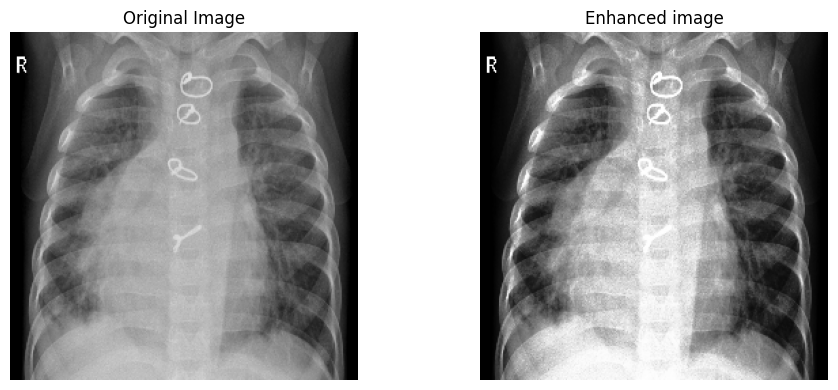

In [ ]:
# Visualize one sample (original vs CLAHE-enhanced)
img = next(train_gen)[0][0].squeeze()  # Get first image from batch
original = img.copy()

img_uint8 = (original * 255).astype(np.uint8)
enhanced = cv2.equalizeHist(img_uint8)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(original, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced, cmap='gray')
plt.title("Enhanced image")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Build CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 classes
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,838,916 (56.61 MB)

 Trainable params: 14,838,916 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=15)
model.save("/content/drive/MyDrive/Dataset/Models/LungDiseasedetectionmodel.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 248s 6s/step - accuracy: 0.5100 - loss: 1.1583 - val_accuracy: 0.8497 - val_loss: 0.4371
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 269s 6s/step - accuracy: 0.8416 - loss: 0.3778 - val_accuracy: 0.9196 - val_loss: 0.2048
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 250s 6s/step - accuracy: 0.9344 - loss: 0.1908 - val_accuracy: 0.9441 - val_loss: 0.1788
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 236s 6s/step - accuracy: 0.9532 - loss: 0.1266 - val_accuracy: 0.9476 - val_loss: 0.1402
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step - accuracy: 0.9760 - loss: 0.0874 - val_accuracy: 0.9510 - val_loss: 0.1674
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 232s 5s/step - accuracy: 0.9574 - loss: 0.1096 - val_accuracy: 0.9406 - val_loss: 0.1561
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - accuracy: 0.9807 - loss: 0.0555 - val_accuracy: 0.9580 - val_loss: 0.1097
Epoch 8/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 235s 6s/step - accuracy: 0.9864 - loss: 0.0449 - val_accuracy: 0.9441 - v

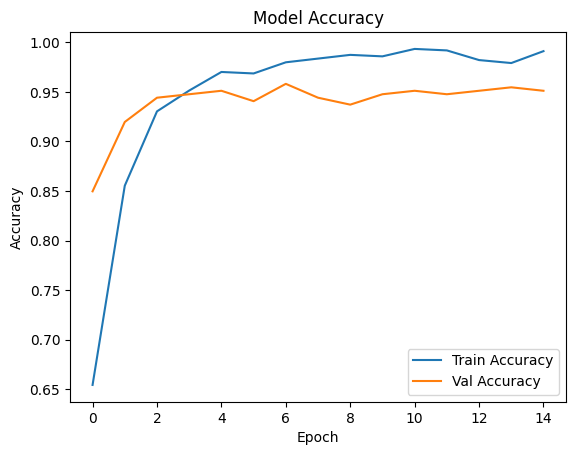

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

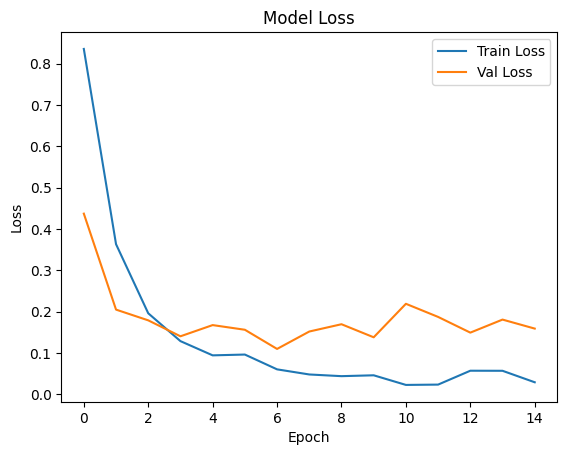

In [ ]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Path to your test data
test_dir = '/content/drive/MyDrive/Dataset/LungDiseaseDetection/DataSplit/test'

# Load the saved model (if you haven’t already)
model = load_model('/content/drive/MyDrive/Dataset/Models/LungDiseasedetectionmodel.h5')

# Define test data generator (no augmentation, just rescale)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),  # Make sure this matches training size
    batch_size=16,
    class_mode='categorical',  # because we have 5 classes
    shuffle=False,
    color_mode='grayscale'  # This is the line to be added
)
# Evaluate on test data
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Found 289 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 666ms/step - accuracy: 0.9179 - loss: 0.2819
Test Accuracy: 93.43%


19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 875ms/step


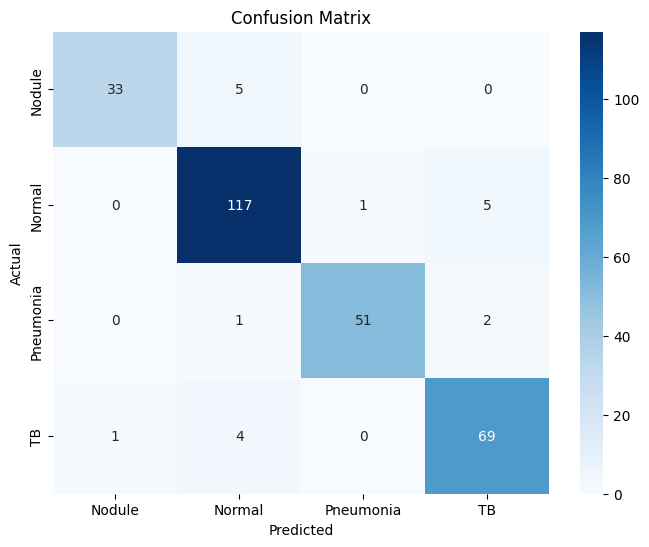

 Classification Report:

              precision    recall  f1-score   support

      Nodule       0.97      0.87      0.92        38
      Normal       0.92      0.95      0.94       123
   Pneumonia       0.98      0.94      0.96        54
          TB       0.91      0.93      0.92        74

    accuracy                           0.93       289
   macro avg       0.95      0.92      0.93       289
weighted avg       0.94      0.93      0.93       289



In [ ]:
# Get predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(" Classification Report:\n")
print(report)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load the classification model
classification_model = load_model('/content/drive/MyDrive/Dataset/Models/LungDiseasedetectionmodel.h5')

# Class names (update if your class order is different)
class_names =  ["Nodule", "Normal", "Pneumonia", "TB"]

def predict_class(image_path):
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (256, 256))
    img_normalized = img_resized / 255.0
    input_img = np.expand_dims(img_normalized, axis=-1)
    input_img = np.expand_dims(input_img, axis=0)

    # Predict
    prediction = classification_model.predict(input_img)[0]
    predicted_class = np.argmax(prediction)
    confidence = prediction[predicted_class] * 100

    # Print result
    print(f"Prediction: {class_names[predicted_class]} ({confidence:.2f}%)")

    # Show the image with prediction title
    plt.imshow(img_resized, cmap='gray')
    plt.title(f"{class_names[predicted_class]} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Prediction: Nodule (99.82%)


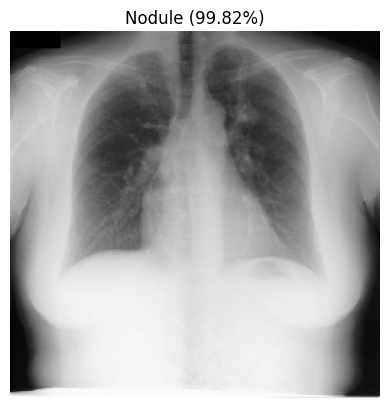

In [ ]:
predict_class("/content/drive/MyDrive/Dataset/LungDiseaseDetection/DataSplit/test/Nodule/JPCLN003.png")

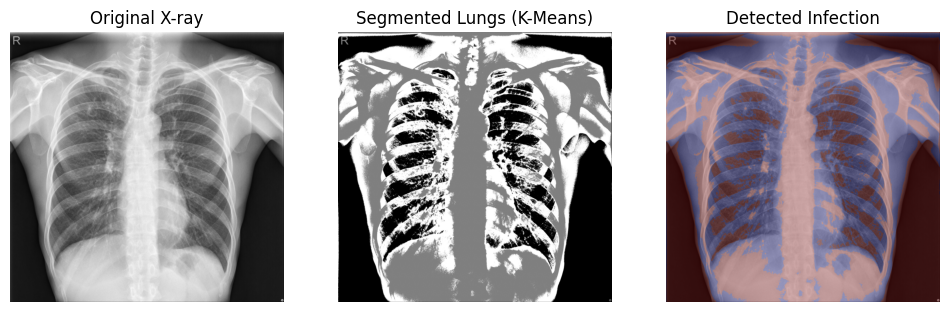

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load X-ray Image
image_path = ""  # Change to your actual image path
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if img is None:
    print("Error: Image not found!")
    exit()

#  Step 1: Apply CLAHE for Contrast Enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_img = clahe.apply(img)

# Step 2: Apply K-means Clustering to Detect Abnormal Regions
Z = enhanced_img.reshape((-1, 1))
Z = np.float32(Z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3  # Number of clusters
_, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert back into an image
segmented = labels.reshape(img.shape)

# Step 3: Convert Segmented Output to Binary Mask
infected_mask = np.uint8(segmented == segmented.max()) * 255

# Step 4: Apply Morphological Operations to Refine Infection Areas
kernel = np.ones((5, 5), np.uint8)
infected_mask = cv2.morphologyEx(infected_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

#  Step 5: Overlay Detected Infected Regions on Original X-ray
heatmap = cv2.applyColorMap(infected_mask, cv2.COLORMAP_JET)
overlay = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), 0.7, heatmap, 0.3, 0)

#  Save & Display the Result
output_path = "infected_result.jpg"
cv2.imwrite(output_path, overlay)

#  Show the images side by side
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title("Original X-ray")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Segmented Lungs (K-Means)")
plt.imshow(segmented, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Detected Infection")
plt.imshow(overlay, cmap="jet")
plt.axis("off")

plt.show()